In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch.optim as optim
from torch.utils.data import random_split
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

In [2]:
sys.path.append('/home/user/sharmav0/CudaLabProject/utils')
import visualizations as visualizations
from base_model import SegModel
from dataset import SegmentationDataset, custom_collate
import common as common 

### DATASET VISUALIZATION

In [4]:
data_dir = '/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3'

train_dataset = SegmentationDataset(data_dir, towns=['01','03','04','05','06','07'], mode = 1, corrupted = True)
val_dataset = SegmentationDataset(data_dir, towns=['02'],mode = 0, corrupted = False)
test_dataset = SegmentationDataset(data_dir, towns=['10'],mode = 0, corrupted = False)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate) 
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)

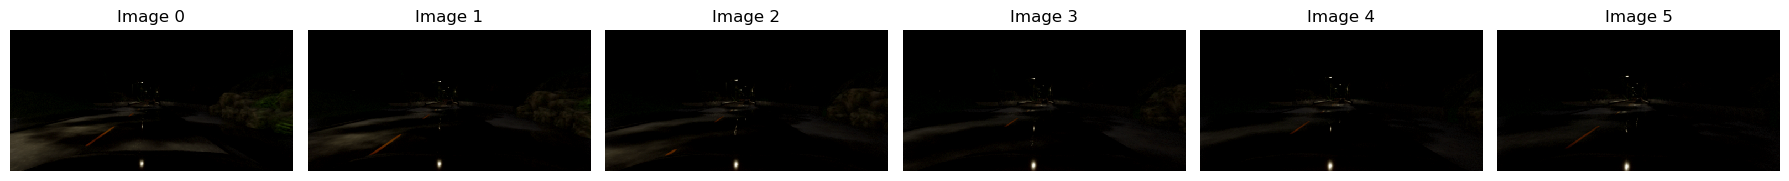

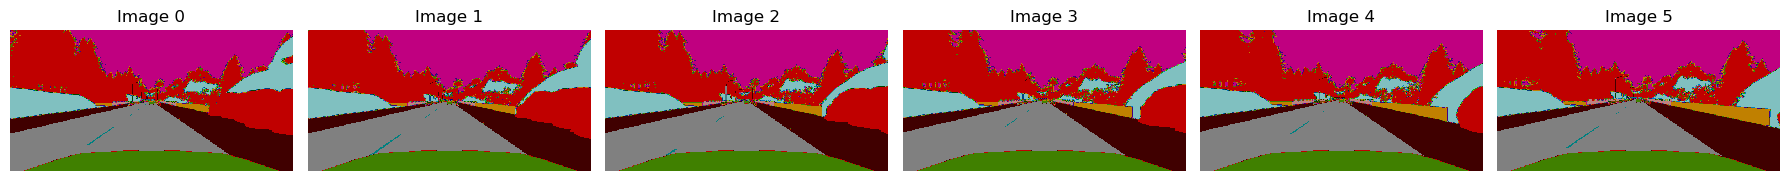

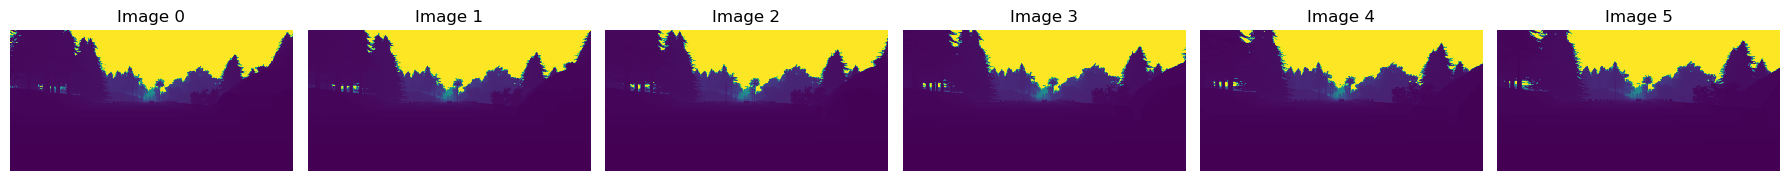

In [6]:
frames, segmentations, depths = train_dataset[160]
frames.size()

seg_vis = (segmentations * 255).long()
seg_vis = visualizations.overlay_segmentations(
    frames=frames, 
    segmentations=seg_vis,
    colors=visualizations.VOC_COLORMAP,
    num_classes=23,
    alpha=1
)

_ = visualizations.visualize_sequence(frames, n_cols=6, unnorm=True)
_ = visualizations.visualize_sequence(seg_vis, n_cols=6)
_ = visualizations.visualize_sequence(depths, n_cols=6, n_channels=1)

### MODEL

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegModel(num_classes=23, backbone=models.resnet34).to(device)

weights = torch.ones(23, device=device)
criterion_seg = nn.CrossEntropyLoss(weight=weights, ignore_index=255)
criterion_depth = nn.L1Loss()  # Depth loss
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)

model, optimizer, epoch, stats, metrics = common.load_model(model, optimizer, "./checkpoints/checkpoint_epoch_4.pth")

TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs")
common.create_dir(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

/home/user/sharmav0/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/sharmav0/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### TRAINING

In [8]:
@torch.no_grad()
def eval_model(model, eval_loader, criterion_seg, criterion_dep, device, epoch, writer):
    # Evaluating the model for either validation or test
    correct_pixels = 0
    total_pixels = 0
    ious = []
    loss_list = []
    loss_list_depth = []

    # for images, labels in tqdm(eval_loader):
    for frames, segmentations, depths in tqdm(eval_loader):

        # images = images.to(device)
        # labels = (labels * 255).long().to(device)
        images = frames.reshape(-1, *frames.shape[2:]).to(device)
        labels = (segmentations.reshape(-1, *segmentations.shape[2:])[:, :1, :, :] * 255).long().to(device)
        depths = depths.reshape(-1, *depths.shape[2:]).to(device)
        labels[labels == 255] = 0
        
        # Forward pass only to get logits/output
        outputs, outputs_depth = model(images)    
        loss = criterion_seg(outputs, labels[:, 0])
        loss_list.append(loss.item())
        loss_depth = criterion_dep(outputs_depth,depths)
        loss_list_depth.append(loss_depth.item())
            
        # computing evaluation metrics
        predicted_class = torch.argmax(outputs, dim=1)
        
        correct_pixels += (predicted_class == labels[:, 0]).sum().item()
        total_pixels += (labels[:, 0] != 255).sum().item()  # Update total pixels excluding ignored class
        
        # Calculate IoU
        iou = common.IoU(predicted_class, labels, num_classes=outputs.shape[1])
        ious.append(iou)

    
    # mean metrics and loss
    loss = np.mean(loss_list)
    loss_depth = np.mean(loss_list_depth)
    avg_accuracy = correct_pixels / total_pixels   
    ious = torch.stack(ious)
    ious = ious.sum(dim=-1) / (ious != 0).sum(dim=-1)  # per class IoU
    mIoU = ious.mean()  # averaging across classes
    
    # creating a visualization for tensorboard
    add_visualization(model, eval_loader, epoch, writer)
    
    return loss,loss_depth, (avg_accuracy, mIoU)


@torch.no_grad()
def add_visualization(model, eval_loader, epoch, writer):
    """ """
    model = model.eval()
    device = "cpu"

    model = model.to(device)
    batch = next(iter(eval_loader))

    frames, segmentations, _ = batch

    imgs = frames.reshape(-1, *frames.shape[2:]).to(device)
    lbls = segmentations.reshape(-1, *segmentations.shape[2:])[:, :1, :, :].to(device)
    lbls[ lbls * 255 == 255] = 0

    outputs,output_depths = model(imgs)
    preds = torch.argmax(outputs, dim=1).unsqueeze(1).to(device)

    imgs = imgs.to(device)
    lbls = lbls.to(device)
    preds = preds.to(device)

    fig, ax = visualizations.qualitative_evaluation(imgs, lbls, preds)
    writer.add_figure("Qualitative Eval", fig, global_step=epoch)
    #fig2 = visualizations.visualize_sequence(output_depths, n_cols=6, n_channels=1)
    #writer.add_figure("Depth Eval", fig2, global_step=epoch)
    
    # move mode back to GPU
    model = model.to("cuda")
    return

In [9]:
def train_epoch(model, train_loader, optimizer, criterion_seg,criterion_dep, epoch, device, writer):
    """ Training a model for one epoch """
    
    loss_list = []
    loss_list_depth = []
    # for i, (images, labels) in enumerate(tqdm(train_loader)):
    for i, (frames,segmentations, depths) in enumerate(tqdm(train_loader)):
        # images = images.to(device)
        # labels = (labels * 255).long().to(device)
        images = frames.reshape(-1, *frames.shape[2:]).to(device)
        labels = (segmentations.reshape(-1, *segmentations.shape[2:])[:, :1, :, :] * 255).long().to(device)
        depths = depths.reshape(-1, *depths.shape[2:]).to(device)

        labels[labels == 255] = 0
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs,outputs_depth = model(images)


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion_seg(outputs, labels[:, 0])
        loss_list.append(loss.item())
        loss_depth = criterion_dep(outputs_depth,depths)
        loss_list_depth.append(loss_depth.item())
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        loss_depth.backward()
         
        # Updating parameters
        optimizer.step()
        
        if i % 30 == 0:
            iter_ = epoch * len(train_loader) + i
            lr = optimizer.param_groups[0]['lr']
            writer.add_scalar(f'Loss/Train Iters', loss.item(), global_step=iter_)
            writer.add_scalar(f'_Params/Learning Rate', lr, global_step=iter_)
    
    print("one epoch done.")
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list

In [10]:
def train_model(model, optimizer, scheduler, criterion1,criterion2, train_loader, valid_loader,
                num_epochs, tboard=None, start_epoch=0):
    """
    Training a model for a given number of epochs
    """
    
    for epoch in range(num_epochs):       
        # validation epoch
        model.eval()  # important for dropout and batch norms
        loss,loss_depth, (mAcc, mIoU) = eval_model(
                model=model,
                eval_loader=valid_loader,
                criterion_seg=criterion1,
                criterion_dep=criterion2,
                device=device,
                epoch=epoch + start_epoch,
                writer=tboard
            )
        tboard.add_scalar(f'Metrics/Valid mAcc', mAcc, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Metrics/Valid mIoU', mIoU, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss_Depth', loss_depth, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model,
                train_loader=train_loader,
                optimizer=optimizer,
                criterion_seg=criterion1,
                criterion_dep=criterion2,
                epoch=epoch + start_epoch,
                device=device,
                writer=tboard
            )
        scheduler.step(loss)
        scheduler.step(loss_depth)
        tboard.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)
        tboard.add_scalars(
                f'Loss/Combined',
                {"train_loss": mean_loss, "valid_loss": loss},
                global_step=epoch+start_epoch
            )
        
        metrics = {'mAcc': mAcc, 'mIoU': mIoU}  # Gather metrics in a dictionary   
        if epoch % 1 == 0:
            common.save_model(model, optimizer, epoch + start_epoch, stats={}, metrics=metrics)
        
    print(f"Training completed")
    return

### EPOCHS

In [ ]:
model.freeze_encoder()
train_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion1=criterion_seg,
        criterion2=criterion_depth,
        train_loader=train_loader,
        valid_loader=valid_loader,
        num_epochs=25,
        tboard=writer,
        start_epoch=0
    )

In [ ]:
# Lowering learning rate and unfreezing encoder
#model.unfreeze_encoder()
#for g in optimizer.param_groups:
#     g['lr'] *= 0.5

In [ ]:
# train_model(
#         model=model,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         criterion1=criterion_seg,
#         criterion2=criterion_depth,
#         train_loader=train_loader,
#         valid_loader=valid_loader,
#         num_epochs=10,
#         tboard=writer,
#         start_epoch=10
#     )

In [9]:
model, optimizer, epoch, stats, metrics = common.load_model(model, optimizer, "./checkpoints/checkpoint_epoch_8.pth")

### TESTING

SegModel(
  (encoder): Backbone(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

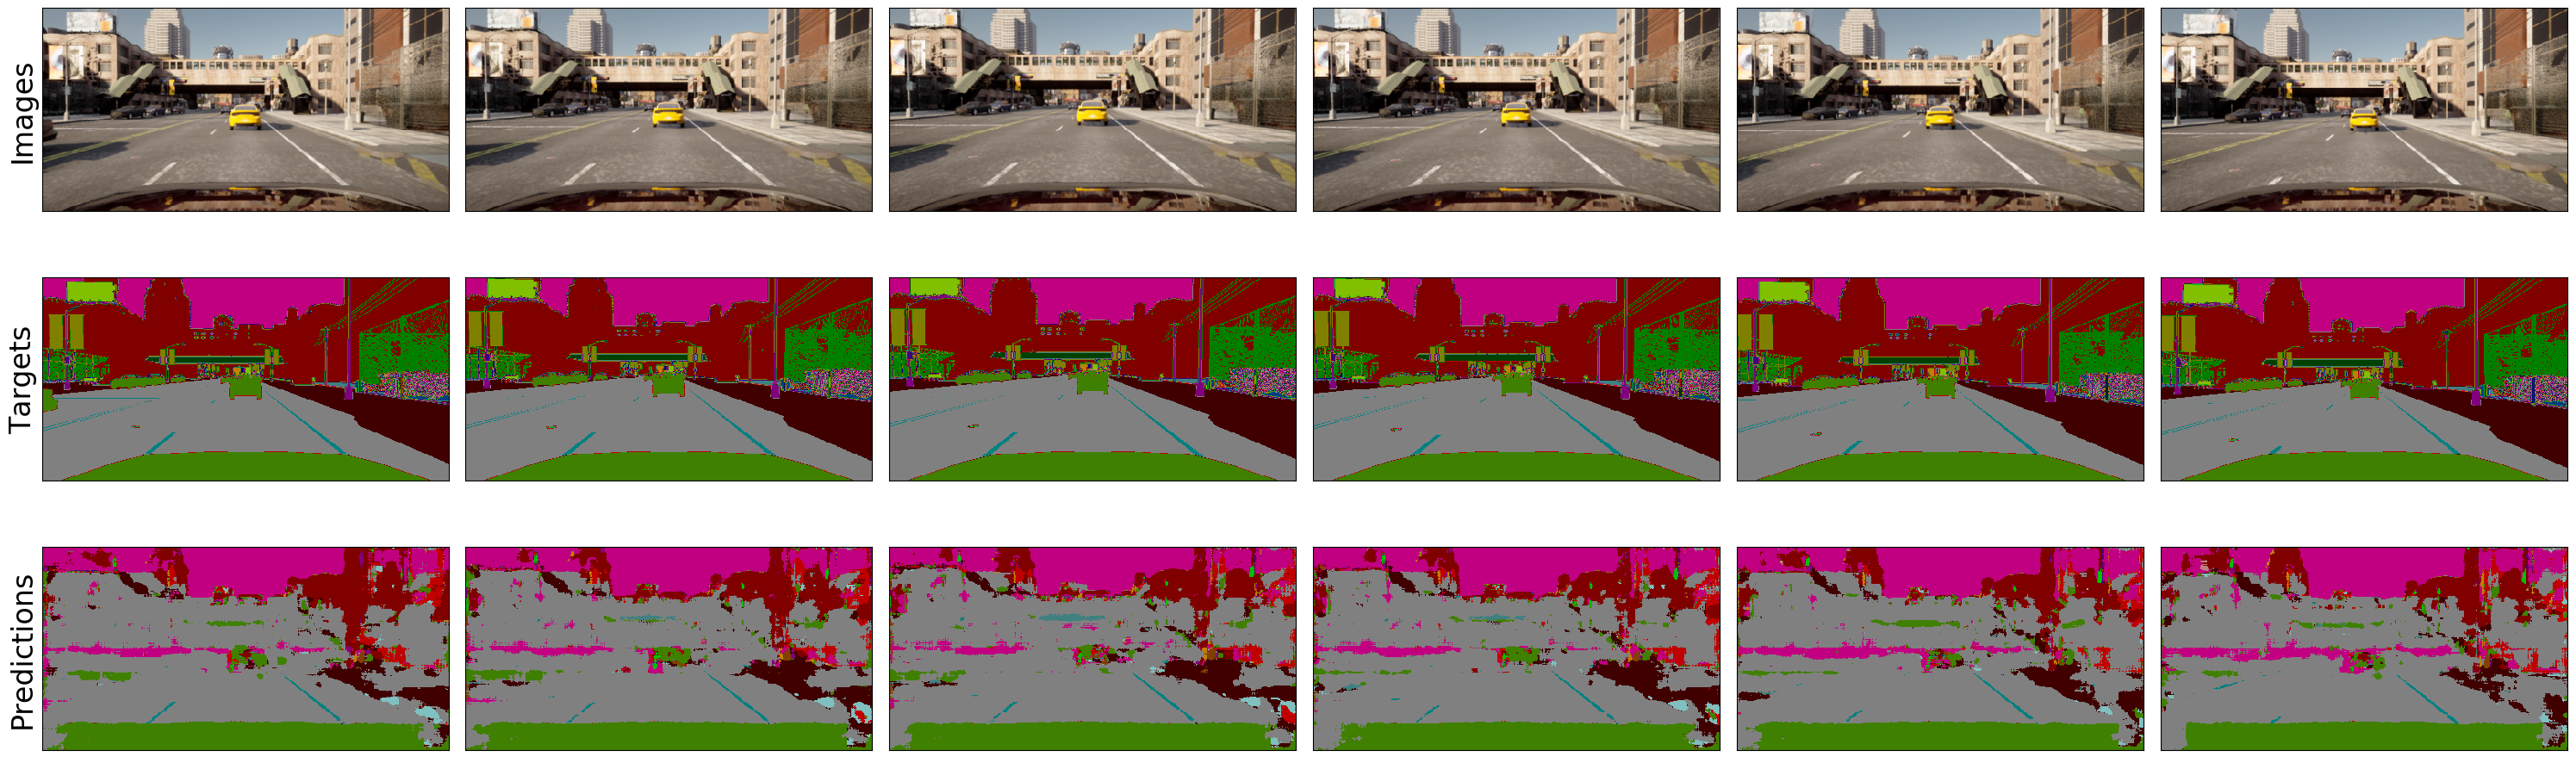

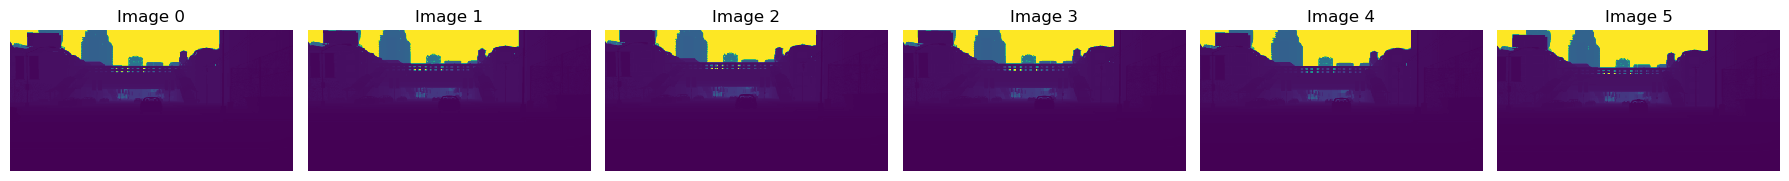

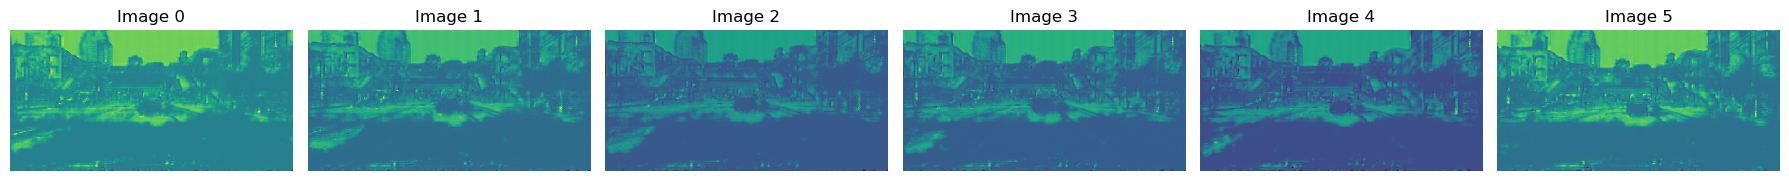

In [12]:
device = "cpu"

model = model.to(device).eval()

batch = (next(iter(test_loader)))

frames, segmentations, depths = batch

imgs = frames.reshape(-1, *frames.shape[2:]).to(device)
lbls = segmentations.reshape(-1, *segmentations.shape[2:])[:, :1, :, :].to(device)
depths = depths.reshape(-1, *depths.shape[2:]).to(device)
lbls[ lbls * 255 == 255] = 0

outputs,output_depths = model(imgs)
preds = torch.argmax(outputs, dim=1).unsqueeze(1).to(device)

imgs = imgs.to(device)
lbls = lbls.to(device)
preds = preds.to(device)

fig, ax = visualizations.qualitative_evaluation(imgs, lbls, preds)

_ = visualizations.visualize_sequence(depths, n_cols=6, n_channels=1)
_ = visualizations.visualize_sequence(output_depths, n_cols=6, n_channels=1)

model.to("cuda")